In [1]:
import numpy as np 
import pandas as pd

import json 
!pip install geopy 
from geopy.geocoders import Nominatim 

import requests 
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans


import folium 
!pip install lxml

In [21]:
CLIENT_ID = 'UH4KVMQX4AIMQLA2XVWPFRIXWRHM1B4GUH4DKVMPZJJTX3LW' # your Foursquare ID
CLIENT_SECRET = 'DUEQVBGVXPW30IE2TYWM5QDJIET5V4USZRV2T1WOOZPYGHPS' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UH4KVMQX4AIMQLA2XVWPFRIXWRHM1B4GUH4DKVMPZJJTX3LW
CLIENT_SECRET:DUEQVBGVXPW30IE2TYWM5QDJIET5V4USZRV2T1WOOZPYGHPS


## The following function is needed to retrieve venues nearby specified locations

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CAT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## We now retrieve data to construct the NY database

In [24]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [25]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [26]:
# define the dataframe columns
column_names = ['Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [27]:
neighborhoods_data = newyork_data['features']

In [28]:
for data in neighborhoods_data:
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [29]:
neighborhoods

,Neighborhood,Latitude,Longitude
0,Wakefield,40.894705,-73.847201
1,Co-op City,40.874294,-73.829939
2,Eastchester,40.887556,-73.827806
3,Fieldston,40.895437,-73.905643
4,Riverdale,40.890834,-73.912585
...,...,...,...
301,Hudson Yards,40.756658,-74.000111
302,Hammels,40.587338,-73.805530
303,Bayswater,40.611322,-73.765968
304,Queensbridge,40.756091,-73.945631


## Using the dataframe neighborhoods we retrieve food locations for every neighborhood. The restriction to only food venues is done by specifying the parameter CAT

In [30]:
CAT='4d4b7105d754a06374d81259'
ny_food = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [197]:
ny_food

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
1,Wakefield,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
2,Wakefield,40.894705,-73.847201,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant
3,Wakefield,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint
4,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
...,...,...,...,...,...,...,...
8157,Fox Hills,40.617311,-74.081740,Bayview Deli,40.620981,-74.072566,Deli / Bodega
8158,Fox Hills,40.617311,-74.081740,Al-Humza,40.611311,-74.088900,Indian Restaurant
8159,Fox Hills,40.617311,-74.081740,Kum Fung Kitchen,40.621842,-74.072305,Chinese Restaurant
8160,Fox Hills,40.617311,-74.081740,The Coffeehouse,40.614638,-74.092345,Café


In [31]:
ny_food['Venue Category'].value_counts()

Pizza Place                  916
Deli / Bodega                515
Italian Restaurant           483
Chinese Restaurant           414
Donut Shop                   371
                            ... 
Egyptian Restaurant            1
Modern Greek Restaurant        1
Japanese Curry Restaurant      1
Souvlaki Shop                  1
Dosa Place                     1
Name: Venue Category, Length: 132, dtype: int64

In [32]:
ny_food.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Allerton,30,30,30,30,30,30
Annadale,17,17,17,17,17,17
Arden Heights,11,11,11,11,11,11
Arlington,12,12,12,12,12,12
Arrochar,19,19,19,19,19,19
...,...,...,...,...,...,...
Woodhaven,30,30,30,30,30,30
Woodlawn,30,30,30,30,30,30
Woodrow,11,11,11,11,11,11


In [33]:
ny_onehot = pd.get_dummies(ny_food[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = ny_food['Neighborhood'] 

In [192]:
ny_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
ny_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint
0,Allerton,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,Annadale,0.0,0.0,0.176471,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,Arden Heights,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,Arlington,0.0,0.0,0.083333,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.083333
4,Arrochar,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Woodhaven,0.0,0.0,0.066667,0.033333,0.0,0.033333,0.0,0.0,0.0,...,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
298,Woodlawn,0.0,0.0,0.066667,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
299,Woodrow,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
300,Woodside,0.0,0.0,0.100000,0.033333,0.0,0.000000,0.0,0.0,0.0,...,0.133333,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


## We check possible numbers of k for the clustering based on food venues and we choose k=5

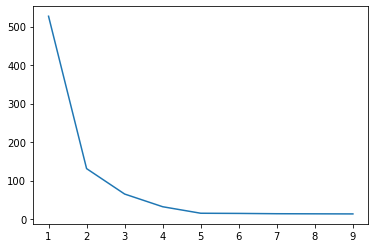

In [197]:
ny_grouped_clustering = ny_grouped.drop('Neighborhood', 1)
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    kmk=km.fit(ny_grouped_clustering)
    sse.append(kmk.inertia_)
plt.plot(list_k, sse)

In [198]:
n_clusters=5
km5=KMeans(n_clusters).fit(ny_grouped_clustering)


In [199]:
ny_grouped['Cluster label']=km5.labels_

In [200]:
ny_grouped

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,...,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Wings Joint,Cluster label
0,Allerton,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2
1,Annadale,0.0,0.0,0.176471,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1
2,Arden Heights,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3
3,Arlington,0.0,0.0,0.083333,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.083333,2
4,Arrochar,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Woodhaven,0.0,0.0,0.066667,0.033333,0.0,0.033333,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2
298,Woodlawn,0.0,0.0,0.066667,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2
299,Woodrow,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,3
300,Woodside,0.0,0.0,0.100000,0.033333,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0


In [201]:
ny_pizza=ny_grouped[['Neighborhood','Pizza Place','Cluster label']]
ny_pizza

,Neighborhood,Pizza Place,Cluster label
0,Allerton,0.200000,2
1,Annadale,0.294118,1
2,Arden Heights,0.090909,3
3,Arlington,0.083333,2
4,Arrochar,0.157895,3
...,...,...,...
297,Woodhaven,0.200000,2
298,Woodlawn,0.200000,2
299,Woodrow,0.090909,3
300,Woodside,0.033333,0


## The followings are the cluster dataframes

In [202]:
ny0=ny_pizza[ny_pizza['Cluster label']==0].reset_index(drop=True)
ny0=ny0.drop(columns=['Cluster label'])
ny0

,Neighborhood,Pizza Place
0,Astoria,0.066667
1,Auburndale,0.066667
2,Bath Beach,0.133333
3,Battery Park City,0.033333
4,Bayside,0.066667
...,...,...
88,Washington Heights,0.100000
89,West Brighton,0.100000
90,Westerleigh,0.033333
91,Windsor Terrace,0.033333


In [203]:

ny1=ny_pizza[ny_pizza['Cluster label']==1].reset_index(drop=True)
ny1=ny1.drop(columns=['Cluster label'])
ny1
    
    


,Neighborhood,Pizza Place
0,Annadale,0.294118
1,Bay Ridge,0.200000
2,Bayswater,0.250000
3,Bedford Park,0.233333
4,Bloomfield,0.400000
5,Borough Park,0.300000
6,Breezy Point,0.500000
7,Bronxdale,0.333333
8,Brownsville,0.233333
9,Bulls Head,0.200000


In [204]:
ny2=ny_pizza[ny_pizza['Cluster label']==2].reset_index(drop=True)
ny2=ny2.drop(columns=['Cluster label'])
ny2

,Neighborhood,Pizza Place
0,Allerton,0.200000
1,Arlington,0.083333
2,Arverne,0.090909
3,Baychester,0.100000
4,Bellaire,0.166667
...,...,...
70,West Farms,0.133333
71,Westchester Square,0.133333
72,Willowbrook,0.083333
73,Woodhaven,0.200000


In [205]:
ny3=ny_pizza[ny_pizza['Cluster label']==3].reset_index(drop=True)
ny3=ny3.drop(columns=['Cluster label'])
ny3

,Neighborhood,Pizza Place
0,Arden Heights,0.090909
1,Arrochar,0.157895
2,Astoria Heights,0.066667
3,Bay Terrace,0.128205
4,Beechhurst,0.100000
5,Belle Harbor,0.000000
6,Belmont,0.166667
7,Bensonhurst,0.100000
8,Carroll Gardens,0.100000
9,Charleston,0.066667


In [206]:
ny4=ny_pizza[ny_pizza['Cluster label']==4].reset_index(drop=True)
ny4=ny4.drop(columns=['Cluster label'])
ny4

,Neighborhood,Pizza Place
0,Cambria Heights,0.095238
1,Canarsie,0.150000
2,East Flatbush,0.111111
3,Eastchester,0.100000
4,Edenwald,0.166667
5,Erasmus,0.133333
6,Flatbush,0.066667
7,Flatlands,0.066667
8,Laurelton,0.066667
9,New Lots,0.133333


## We define a new dataframe that we use to show on the map the clustering

In [227]:
neigh_clustered=neighborhoods.join(ny_pizza.set_index('Neighborhood'), on='Neighborhood')
neigh_clustered=neigh_clustered.drop(columns=['Pizza Place'])
neigh_clustered

,Neighborhood,Latitude,Longitude,Cluster label
0,Wakefield,40.894705,-73.847201,4
1,Co-op City,40.874294,-73.829939,2
2,Eastchester,40.887556,-73.827806,4
3,Fieldston,40.895437,-73.905643,2
4,Riverdale,40.890834,-73.912585,1
...,...,...,...,...
301,Hudson Yards,40.756658,-74.000111,0
302,Hammels,40.587338,-73.805530,2
303,Bayswater,40.611322,-73.765968,1
304,Queensbridge,40.756091,-73.945631,0


In [223]:
# create map
map_clusters = folium.Map(location=[40.7127281, -74.0060152], zoom_start=11)

# set color scheme for the clusters
x = np.arange(n_clusters)
ys = [i + x + (i*x)**2 for i in range(n_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neigh_clustered['Latitude'], neigh_clustered['Longitude'], neigh_clustered['Neighborhood'], neigh_clustered['Cluster label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## We use boxplots to find possible outliers in each cluster for what concerns pizza places distribution

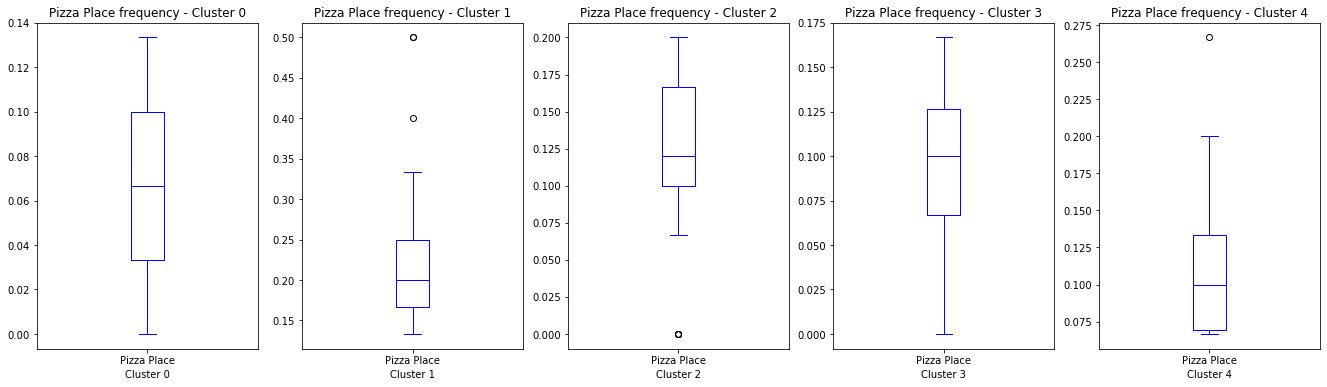

In [212]:
fig = plt.figure() # create figure

ax0 = fig.add_subplot(1, 5, 1) 
ax1 = fig.add_subplot(1, 5, 2) 
ax2 = fig.add_subplot(1, 5, 3)
ax3 = fig.add_subplot(1, 5, 4)
ax4 = fig.add_subplot(1, 5, 5)

ny0.plot(kind='box', color='blue',  figsize=(23, 6), ax=ax0) # add to subplot 1
ax0.set_title('Pizza Place frequency - Cluster 0')
ax0.set_xlabel('Cluster 0')

ny1.plot(kind='box', color='blue', figsize=(23, 6), ax=ax1) # add to subplot 1
ax1.set_title('Pizza Place frequency - Cluster 1')
ax1.set_xlabel('Cluster 1')

ny2.plot(kind='box', color='blue', figsize=(23, 6), ax=ax2) # add to subplot 1
ax2.set_title('Pizza Place frequency - Cluster 2')
ax2.set_xlabel('Cluster 2')

ny3.plot(kind='box', color='blue', figsize=(23, 6), ax=ax3) # add to subplot 1
ax3.set_title('Pizza Place frequency - Cluster 3')
ax3.set_xlabel('Cluster 3')

ny4.plot(kind='box', color='blue', figsize=(23, 6), ax=ax4) # add to subplot 1
ax4.set_title('Pizza Place frequency - Cluster 4')
ax4.set_xlabel('Cluster 4')


plt.show()

# We see that there are outliers in cluster 2, we find them and show them on a map

In [232]:
result=ny2[ny2['Pizza Place']==0]
result

,Neighborhood,Pizza Place
12,Butler Manor,0.0
60,Roxbury,0.0
63,South Beach,0.0
67,Todt Hill,0.0


In [233]:
newpizza=result.join(neigh_clustered.set_index('Neighborhood'),on='Neighborhood')
newpizza

,Neighborhood,Pizza Place,Latitude,Longitude,Cluster label
12,Butler Manor,0.0,40.506082,-74.229504,2
60,Roxbury,0.0,40.567376,-73.892138,2
63,South Beach,0.0,40.580247,-74.079553,2
67,Todt Hill,0.0,40.597069,-74.111329,2


In [240]:
map_pizza_openings = folium.Map(location=[40.7127281, -74.0060152], zoom_start=10)


# add markers to the map
for lat, lon, poi in zip(newpizza['Latitude'], newpizza['Longitude'], newpizza['Neighborhood']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        
        fill_opacity=0.7).add_to(map_pizza_openings)
       
map_pizza_openings